In [1]:
%load_ext autoreload
%autoreload 1

import sys
import torch
import os
import imageio
import time
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import pandas as pd
import ast
import timm
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import save, load
from torchsummary import summary 

import torch
import torchvision.transforms as transforms
import pandas as pd
import ast
import timm
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

from usflc_xai import models, datasets

%aimport usflc_xai
from usflc_xai import models, datasets, training

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Configuration
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset' + str(test_data_id) + '/test_dataset' + str(test_data_id) + '.csv'
ckpt_name = 'model_tl_twbabd' + str(test_data_id) + '/best_results.ckpt'
image_encoder_id = 'densenet121'
graph_encoder_id = 'SETNET_GAT'
num_classes = 2
input_dim = 1024
num_layers = 1

# Load metadata and test data list
meta_data = pd.read_csv(metadata_name, sep=",")
test_data_list = pd.read_csv(test_data_list_name)

# Transform function
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load pretrained image encoder
_, pretrained_image_encoder = models.image_encoder_model(
    name=image_encoder_id,
    pretrained=True,
    num_classes=num_classes,
    device=device
)
pretrained_image_encoder = pretrained_image_encoder.eval()

# Load graph encoder
graph_encoder, _ = models.encoder_model(
    name=graph_encoder_id,
    input_dim=input_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    device=device
)

# Load checkpoint
checkpoint = torch.load(ckpt_name)
graph_encoder.load_state_dict(checkpoint['model_state_dict'])
graph_encoder = graph_encoder.eval()

# # Prediction function
def predict_fn(images):
    image_features = []
    for img in images:
        img = transform(Image.fromarray((img * 255).astype(np.uint8))).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = pretrained_image_encoder(img)
        image_features.append(feature.squeeze(0))
    
    # Create a batch tensor from image features
    image_features = torch.stack(image_features)
    
    # Create dummy edge_index and batch
    num_images = len(images)
    edge_index = torch.tensor([[i, j] for i in range(num_images) for j in range(num_images) if i != j], dtype=torch.long).t().contiguous().to(device)
    batch = torch.arange(num_images, dtype=torch.long).to(device)
    
    # Create dummy Data object for graph encoder
    data = Data(x=image_features.to(device),
                edge_index=edge_index,
                y=torch.tensor([0]*num_images, dtype=torch.long).to(device))  # Dummy labels
    
    # Predict
    with torch.no_grad():
        output = graph_encoder(data.x, data.edge_index, batch, 1)  # Assuming train_mask is 1
        probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()
    return probs

In [3]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
import glob 
import datetime

In [4]:
def safe_heatmap_conversion(heatmap):
    # Convert to a numpy array if it's not already
    heatmap_array = np.array(heatmap)
    
    # Create a mask for None values
    none_mask = heatmap_array == None
    
    # Convert to float, replacing None with np.nan
    heatmap_float = np.where(none_mask, np.nan, heatmap_array.astype(float))
    
    return heatmap_float


def explaination_heatmap(dict_heatmap: dict, explanation, i_img_save_dir: str, label, label_indx: int, img_indx: int):
    
    #Map each explanation weight to the corresponding superpixel
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    heatmap_float = safe_heatmap_conversion(heatmap)
    print(f"Heatmap dtype: {heatmap.dtype}")
    
    # Check if heatmap contains any non-nan values
    if np.any(~np.isnan(heatmap_float)):
        # Remove nan values for calculating vmax
        heatmap_no_nan = heatmap_float[~np.isnan(heatmap_float)]
        vmax = np.max(np.abs(heatmap_no_nan))
        
        # Plot. The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap_float, cmap='RdBu', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        plt.title(f"Heatmap for label {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"heatmap-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
    else:
        print(f"Skipping heatmap for label {label} due to no valid data")

## No Segmentation 

In [5]:
# LIME explanation
explainer = lime_image.LimeImageExplainer()
IMG_FILEPATHS = glob.glob("/home/liuusa_tw/data/TWBABD_US_images_5_instances_13062024/P0018600/*.jpg")
images = np.array([plt.imread(i) for i in IMG_FILEPATHS])
GLOBAL_RESULT_DIR = "/home/liuusa_tw/twbabd_image_xai_20062024/lime_test_results/"
assert(os.path.exists(GLOBAL_RESULT_DIR))
assert(all(os.path.exists(i) for i in IMG_FILEPATHS))

print(meta_data[(meta_data['MI_ID'] == "P0018600")]['liver_fatty'])
assert(1 == len(meta_data[(meta_data['MI_ID'] == "P0018600")]['liver_fatty'].tolist()))
SUBJ_GROUND_TRUTH_LABEL = meta_data[(meta_data['MI_ID'] == "P0018600")]['liver_fatty'].tolist()[0]

18473    1
Name: liver_fatty, dtype: int64


In [6]:
print(SUBJ_GROUND_TRUTH_LABEL)
RESULT_DIR = os.path.join(GLOBAL_RESULT_DIR, f"no_seg-{datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')}")
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)

for img_indx, i_img in tqdm(enumerate(images[:1])):
# for img_indx, i_img in tqdm(enumerate(images)):
    explanation = explainer.explain_instance(i_img, 
                                             predict_fn, 
                                             top_labels=20, 
                                             hide_color=0, 
                                             num_features=100, 
                                             num_samples=500)

    print(IMG_FILEPATHS[img_indx])
    i_img_save_dir = os.path.join(RESULT_DIR, f"{img_indx}/")
    os.mkdir(i_img_save_dir)
    plt.imshow(i_img, cmap='gray')
    plt.savefig(os.path.join(i_img_save_dir, f"original-{img_indx}.png"))
    plt.show()
    
    # assert(isinstance(explanation.top_labels[0], type(SUBJ_GROUND_TRUTH_LABEL)))

    # Visualization
    for label_indx, label in enumerate(explanation.top_labels):
        if label != SUBJ_GROUND_TRUTH_LABEL: continue
        print(label_indx, label)
        
        print("10 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"10-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
            
        print("100 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"100-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
        
        explaination_heatmap(dict_heatmap = dict(explanation.local_exp[label]), 
                             explanation = explanation, 
                             i_img_save_dir = i_img_save_dir, 
                             label = label, 
                             label_indx = label_indx,
                             img_indx = img_indx)
        

1


0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

(500, 100) (500,) ()
copied shape
(500, 100) (500,) ()


0it [00:30, ?it/s]

Dimensions of y_true (250,) do not match y_pred (500,)
Length of values (101) does not match length of index (501)


ValueError: Length of values (101) does not match length of index (501)

## SLIC Segmentation (K-Means Clustering)

### Test on One Image

In [ ]:

# Creating a segmenter
slic_segmenter = SegmentationAlgorithm(algo_type="slic",
                                       enforce_connectivity=True, 
                                       max_num_iter=50,
                                       compactnessfloat = 10.0,
                                       n_segments = 100,
                                       sigma =0.0,)


explanation = explainer.explain_instance(images[0], 
                                         predict_fn, 
                                         top_labels=20, 
                                         hide_color=0, 
                                         num_features=100, 
                                         num_samples=1000,
                                         segmentation_fn=slic_segmenter,)

print(IMG_FILEPATHS[0])
plt.imshow(images[0], cmap='gray')
plt.show()

    # Visualization
for label in explanation.top_labels:
        
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
    plt.imshow(temp, cmap='gray')
    plt.title(f"Top label: {label}")
    plt.show()
    
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
    plt.imshow(temp, cmap='gray')
    plt.title(f"Top label: {label}")
    plt.show()
        
    #Select the same class explained on the figures above.
    ind = label
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    heatmap_float = safe_heatmap_conversion(heatmap)
    print(f"Heatmap dtype: {heatmap.dtype}")
    # Check if heatmap contains any non-nan values
    if np.any(~np.isnan(heatmap_float)):
        # Remove nan values for calculating vmax
        heatmap_no_nan = heatmap_float[~np.isnan(heatmap_float)]
        vmax = np.max(np.abs(heatmap_no_nan))
        # Plot. The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap_float, cmap='RdBu', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        plt.title(f"Heatmap for label {label}")
        plt.show()
    else:
        print(f"Skipping heatmap for label {label} due to no valid data")

### Apply on All Images

In [ ]:
print(SUBJ_GROUND_TRUTH_LABEL)
RESULT_DIR = os.path.join(GLOBAL_RESULT_DIR, f"slic-{datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')}")
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)

for img_indx, i_img in tqdm(enumerate(images)):
    # Creating a segmenter
    slic_segmenter = SegmentationAlgorithm(algo_type="slic",
                                        enforce_connectivity=True, 
                                        max_num_iter=50,
                                        compactnessfloat = 10.0,
                                        n_segments = 100,
                                        sigma =0.0,)
    explanation = explainer.explain_instance(i_img, 
                                         predict_fn, 
                                         top_labels=20, 
                                         hide_color=0, 
                                         num_features=100, 
                                         num_samples=1000,
                                         segmentation_fn=slic_segmenter,)

    print(IMG_FILEPATHS[img_indx])
    i_img_save_dir = os.path.join(RESULT_DIR, f"{img_indx}/")
    os.mkdir(i_img_save_dir)
    plt.imshow(i_img, cmap='gray')
    plt.savefig(os.path.join(i_img_save_dir, f"original-{img_indx}.png"))
    plt.show()
    
    # assert(isinstance(explanation.top_labels[0], type(SUBJ_GROUND_TRUTH_LABEL)))

    # Visualization
    for label_indx, label in enumerate(explanation.top_labels):
        if label != SUBJ_GROUND_TRUTH_LABEL: continue
        print(label_indx, label)
        
        print("10 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"10-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
            
        
        print("100 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"100-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
        
        explaination_heatmap(dict_heatmap = dict(explanation.local_exp[label]), 
                             explanation = explanation, 
                             i_img_save_dir = i_img_save_dir, 
                             label = label, 
                             label_indx = label_indx,
                             img_indx = img_indx)

# SLIC + ElasticNet

Default LIME uses Ridge regression (`model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)`), let's try something different

In [ ]:
from sklearn.linear_model import ElasticNet
elasticnet_regressor = ElasticNet()

print(SUBJ_GROUND_TRUTH_LABEL)
RESULT_DIR = os.path.join(GLOBAL_RESULT_DIR, f"slic-elasticnet-{datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')}")
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)

for img_indx, i_img in tqdm(enumerate(images)):
    # Creating a segmenter
    slic_segmenter = SegmentationAlgorithm(algo_type="slic",
                                        enforce_connectivity=True, 
                                        max_num_iter=50,
                                        compactnessfloat = 10.0,
                                        n_segments = 100,
                                        sigma =0.0,)
    explanation = explainer.explain_instance(i_img, 
                                         predict_fn, 
                                         top_labels=20, 
                                         hide_color=0, 
                                         num_features=100, 
                                         num_samples=1000,
                                         segmentation_fn=slic_segmenter,
                                         model_regressor = elasticnet_regressor,)

    print(IMG_FILEPATHS[img_indx])
    i_img_save_dir = os.path.join(RESULT_DIR, f"{img_indx}/")
    os.mkdir(i_img_save_dir)
    plt.imshow(i_img, cmap='gray')
    plt.savefig(os.path.join(i_img_save_dir, f"original-{img_indx}.png"))
    plt.show()
    
    # assert(isinstance(explanation.top_labels[0], type(SUBJ_GROUND_TRUTH_LABEL)))

    # Visualization
    for label_indx, label in enumerate(explanation.top_labels):
        if label != SUBJ_GROUND_TRUTH_LABEL: continue
        print(label_indx, label)
        
        print("10 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"10-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
            
        
        print("100 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"100-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
        
        explaination_heatmap(dict_heatmap = dict(explanation.local_exp[label]), 
                             explanation = explanation, 
                             i_img_save_dir = i_img_save_dir, 
                             label = label, 
                             label_indx = label_indx,
                             img_indx = img_indx)

In [54]:
elasticnet_regressor.coef_

array([ 0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,
        0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
       -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,
       -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,
        0.,  0., -0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,  0.,
       -0., -0., -0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0.,  0.,
       -0., -0.,  0.,  0.,  0.,  0., -0., -0.])

# SLIC + Huber Regression

Default LIME uses Ridge regression (`model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)`), let's try something different

1


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/liuusa_tw/data/TWBABD_US_images_5_instances_13062024/P0018600/P0018600_IMG0005.jpg


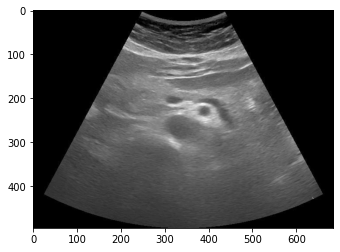

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 1
10 Features


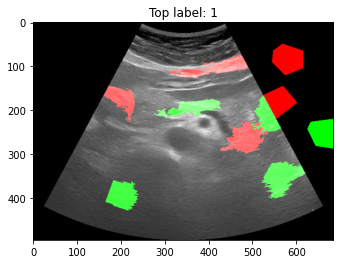

100 Features


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


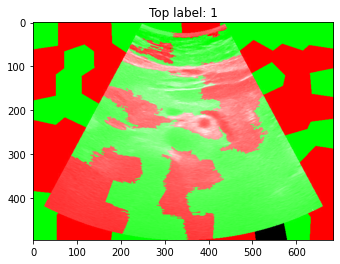

Heatmap dtype: float64


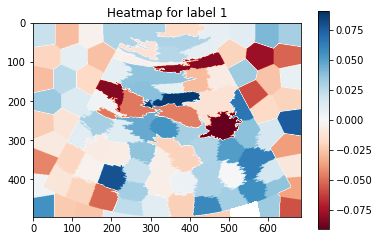

1it [00:37, 37.41s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1it [00:43, 43.42s/it]


KeyboardInterrupt: 

In [6]:
from sklearn.linear_model import HuberRegressor
huber_regressor = HuberRegressor()

print(SUBJ_GROUND_TRUTH_LABEL)
RESULT_DIR = os.path.join(
    GLOBAL_RESULT_DIR, f"slic-huber-{datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')}")
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)

for img_indx, i_img in tqdm(enumerate(images)):
    # Creating a segmenter
    slic_segmenter = SegmentationAlgorithm(algo_type="slic",
                                           enforce_connectivity=True,
                                           max_num_iter=50,
                                           compactnessfloat=10.0,
                                           n_segments=100,
                                           sigma=0.0,)
    explanation = explainer.explain_instance(i_img,
                                             predict_fn,
                                             top_labels=20,
                                             hide_color=0,
                                             num_features=100,
                                             num_samples=1000,
                                             segmentation_fn=slic_segmenter,
                                             model_regressor=huber_regressor,)

    print(IMG_FILEPATHS[img_indx])
    i_img_save_dir = os.path.join(RESULT_DIR, f"{img_indx}/")
    os.mkdir(i_img_save_dir)
    plt.imshow(i_img, cmap='gray')
    plt.savefig(os.path.join(i_img_save_dir, f"original-{img_indx}.png"))
    plt.show()

    # assert(isinstance(explanation.top_labels[0], type(SUBJ_GROUND_TRUTH_LABEL)))

    # Visualization
    for label_indx, label in enumerate(explanation.top_labels):
        if label != SUBJ_GROUND_TRUTH_LABEL:
            continue
        print(label_indx, label)

        print("10 Features")
        temp, mask = explanation.get_image_and_mask(
            label, positive_only=False, num_features=10, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir,
                    f"10-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()

        print("100 Features")
        temp, mask = explanation.get_image_and_mask(
            label, positive_only=False, num_features=100, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir,
                    f"100-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()

        explaination_heatmap(dict_heatmap=dict(explanation.local_exp[label]),
                             explanation=explanation,
                             i_img_save_dir=i_img_save_dir,
                             label=label,
                             label_indx=label_indx,
                             img_indx=img_indx)

In [9]:
from regressors import stats as regressors_stats
regressors_stats.summary(huber_regressor)

TypeError: summary() missing 2 required positional arguments: 'X' and 'y'

In [56]:
huber_regressor.coef_

array([ 0.11236368,  0.08903309,  0.09099412,  0.0853037 ,  0.06596512,
       -0.07594612,  0.06553835,  0.04359237,  0.05159981, -0.06094562,
       -0.05525592, -0.05958448,  0.0525338 ,  0.06648859,  0.05989488,
        0.04310432,  0.04384075,  0.05098042,  0.04203755, -0.04218267,
        0.03904656,  0.04190726, -0.03932385,  0.04102371,  0.0495213 ,
        0.03174921, -0.04899935,  0.04477686, -0.02761778,  0.04327351,
        0.01972634,  0.03335863, -0.04165412,  0.02534928,  0.03767043,
       -0.02951114,  0.04212299, -0.0501557 ,  0.04765877,  0.02779411,
        0.02847063,  0.0309361 ,  0.02140815, -0.04133086,  0.0273671 ,
        0.03363975,  0.02866548,  0.02402634, -0.01773533,  0.01928047,
        0.02144834, -0.02136222, -0.02137349,  0.01931827,  0.03432489,
       -0.01841459,  0.03534771,  0.02701596,  0.02991699,  0.02581836,
        0.0008013 , -0.01108832,  0.01616341,  0.00412778,  0.01900735,
        0.0178937 , -0.01440516, -0.00588496, -0.00808837, -0.01

# SLIC + Stochastic Gradient Descent Regression

Default LIME uses Ridge regression (`model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)`), let's try something different

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_regressor = SGDRegressor()

print(SUBJ_GROUND_TRUTH_LABEL)
RESULT_DIR = os.path.join(GLOBAL_RESULT_DIR, f"slic-sgd-{datetime.datetime.now().strftime('%m-%d-%Y-%H-%M-%S')}")
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)

for img_indx, i_img in tqdm(enumerate(images)):
    # Creating a segmenter
    slic_segmenter = SegmentationAlgorithm(algo_type="slic",
                                        enforce_connectivity=True, 
                                        max_num_iter=50,
                                        compactnessfloat = 10.0,
                                        n_segments = 100,
                                        sigma =0.0,)
    explanation = explainer.explain_instance(i_img, 
                                         predict_fn, 
                                         top_labels=20, 
                                         hide_color=0, 
                                         num_features=100, 
                                         num_samples=1000,
                                         segmentation_fn=slic_segmenter,
                                         model_regressor = sgd_regressor,)

    print(IMG_FILEPATHS[img_indx])
    i_img_save_dir = os.path.join(RESULT_DIR, f"{img_indx}/")
    os.mkdir(i_img_save_dir)
    plt.imshow(i_img, cmap='gray')
    plt.savefig(os.path.join(i_img_save_dir, f"original-{img_indx}.png"))
    plt.show()
    
    # assert(isinstance(explanation.top_labels[0], type(SUBJ_GROUND_TRUTH_LABEL)))

    # Visualization
    for label_indx, label in enumerate(explanation.top_labels):
        if label != SUBJ_GROUND_TRUTH_LABEL: continue
        print(label_indx, label)
        
        print("10 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"10-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
            
        
        print("100 Features")
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
        plt.imshow(temp, cmap='gray')
        plt.title(f"Top label: {label}")
        plt.savefig(os.path.join(i_img_save_dir, f"100-{img_indx}-{label_indx}-label{label}.png"))
        plt.show()
        
        explaination_heatmap(dict_heatmap = dict(explanation.local_exp[label]), 
                             explanation = explanation, 
                             i_img_save_dir = i_img_save_dir, 
                             label = label, 
                             label_indx = label_indx,
                             img_indx = img_indx)

In [58]:
sgd_regressor.coef_

array([ 0.07538919,  0.0565968 ,  0.03998415,  0.04730976,  0.0376021 ,
        0.04252771, -0.04009612,  0.04698362,  0.03851961,  0.03673525,
       -0.03611567, -0.03627432,  0.03725821,  0.04077608,  0.03344057,
        0.03250151,  0.03082583, -0.02316186,  0.02549842,  0.03193562,
       -0.02704286,  0.02507656,  0.0245081 , -0.03022992,  0.02588604,
       -0.02189909,  0.02754602,  0.02811577, -0.01675717,  0.02478221,
        0.02190288,  0.02379867, -0.01531699, -0.0149034 ,  0.01688839,
       -0.01389904,  0.0161575 ,  0.01752715, -0.01650684,  0.01386685,
        0.01879792, -0.01941501, -0.01161554, -0.01389818,  0.02184321,
        0.01755993, -0.01275149, -0.00852199,  0.01395164,  0.01113956,
        0.01086418,  0.01386606, -0.01228519, -0.01144819, -0.00932565,
        0.01123082,  0.01512602, -0.00311345, -0.00841207, -0.00399251,
       -0.00567207, -0.01215176,  0.00636509, -0.00450665,  0.00780186,
        0.01244441, -0.00451314, -0.00637113, -0.00308646,  0.00

# TESTING

## Quickshift Segmentation

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Creating a segmenter
quickshift_segmenter = SegmentationAlgorithm(algo_type="quickshift",                                 
                                  kernel_size=1, 
                                  max_dist=2)


explanation = explainer.explain_instance(images[0], 
                                         predict_fn, 
                                         top_labels=10, 
                                         hide_color=0, 
                                         num_features=100, 
                                         num_samples=500,
                                         segmentation_fn=quickshift_segmenter,)

print(IMG_FILEPATHS[0])
plt.imshow(images[0], cmap='gray')
plt.show()

    # Visualization
for label in explanation.top_labels:
        
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
    plt.imshow(temp, cmap='gray')
    plt.title(f"Top label: {label}")
    plt.show()
    
    #Select the same class explained on the figures above.
    ind = label
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    heatmap_float = safe_heatmap_conversion(heatmap)
    print(f"Heatmap dtype: {heatmap.dtype}")
    
    # Check if heatmap contains any non-nan values
    if np.any(~np.isnan(heatmap_float)):
        # Remove nan values for calculating vmax
        heatmap_no_nan = heatmap_float[~np.isnan(heatmap_float)]
        vmax = np.max(np.abs(heatmap_no_nan))
        
        # Plot. The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap_float, cmap='RdBu', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        plt.title(f"Heatmap for label {label}")
        plt.show()
    else:
        print(f"Skipping heatmap for label {label} due to no valid data")
    
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
    plt.imshow(temp, cmap='gray')
    plt.title(f"Top label: {label}")
    plt.show()
    
    #Select the same class explained on the figures above.
    ind = label
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    heatmap_float = safe_heatmap_conversion(heatmap)
    print(f"Heatmap dtype: {heatmap.dtype}")
    
    # Check if heatmap contains any non-nan values
    if np.any(~np.isnan(heatmap_float)):
        # Remove nan values for calculating vmax
        heatmap_no_nan = heatmap_float[~np.isnan(heatmap_float)]
        vmax = np.max(np.abs(heatmap_no_nan))
        
        # Plot. The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap_float, cmap='RdBu', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        plt.title(f"Heatmap for label {label}")
        plt.show()
    else:
        print(f"Skipping heatmap for label {label} due to no valid data")

## Felsenszwalb's efficient graph based image segmentation

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Creating a segmenter
felzenszwalb_segmenter = SegmentationAlgorithm(algo_type="felzenszwalb",
                                               scale = 1, 
                                               min_size = 10,
                                               sigma = 0.8)


explanation = explainer.explain_instance(images[0], 
                                         predict_fn, 
                                         top_labels=10, 
                                         hide_color=0, 
                                         num_features=100, 
                                         num_samples=1000,
                                         segmentation_fn=felzenszwalb_segmenter,)

print(IMG_FILEPATHS[0])
plt.imshow(images[0], cmap='gray')
plt.show()

    # Visualization
for label in explanation.top_labels:
        
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
    plt.imshow(temp, cmap='gray')
    plt.title(f"Top label: {label}")
    plt.show()
    

    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
    plt.imshow(temp, cmap='gray')
    plt.title(f"Top label: {label}")
    plt.show()
    
    #Select the same class explained on the figures above.
    ind = label
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    heatmap_float = safe_heatmap_conversion(heatmap)
    print(f"Heatmap dtype: {heatmap.dtype}")
    
    # Check if heatmap contains any non-nan values
    if np.any(~np.isnan(heatmap_float)):
        # Remove nan values for calculating vmax
        heatmap_no_nan = heatmap_float[~np.isnan(heatmap_float)]
        vmax = np.max(np.abs(heatmap_no_nan))
        
        # Plot. The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap_float, cmap='RdBu', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        plt.title(f"Heatmap for label {label}")
        plt.show()
    else:
        print(f"Skipping heatmap for label {label} due to no valid data")

## Random Tests

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Configuration
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset' + str(test_data_id) + '/test_dataset' + str(test_data_id) + '.csv'
ckpt_name = 'model_tl_twbabd' + str(test_data_id) + '/best_results.ckpt'
image_encoder_id = 'densenet121'
graph_encoder_id = 'SETNET_GAT'
num_classes = 2
input_dim = 1024
num_layers = 1

# Load metadata and test data list
meta_data = pd.read_csv(metadata_name, sep=",")
test_data_list = pd.read_csv(test_data_list_name)

# Transform function
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load pretrained image encoder
_, pretrained_image_encoder = models.image_encoder_model(
    name=image_encoder_id,
    pretrained=True,
    num_classes=num_classes,
    device=device
)
pretrained_image_encoder = pretrained_image_encoder.eval()

# Load graph encoder
graph_encoder, _ = models.encoder_model(
    name=graph_encoder_id,
    input_dim=input_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    device=device
)

# Load checkpoint
checkpoint = torch.load(ckpt_name)
graph_encoder.load_state_dict(checkpoint['model_state_dict'])
graph_encoder = graph_encoder.eval()

# Prediction function
def predict_fn(images):
    image_features = []
    for img in images:
        img = transform(Image.fromarray((img * 255).astype(np.uint8))).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = pretrained_image_encoder(img)
        image_features.append(feature.squeeze(0).cpu().numpy())
    
    # Dummy edge_index and batch (adapt this according to your specific use case)
    edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)
    batch = torch.zeros(len(images), dtype=torch.long)
    
    # Create dummy Data object for graph encoder
    data = Data(x=torch.tensor(image_features, dtype=torch.float).to(device),
                edge_index=edge_index.to(device),
                y=torch.tensor([0]*len(images), dtype=torch.long).to(device))  # Dummy labels
    
    # Predict
    with torch.no_grad():
        output = graph_encoder(data.x, data.edge_index, batch, 1)  # Assuming train_mask is 1
        probs = F.softmax(output, dim=1).cpu().numpy()
    return probs

# LIME explanation
explainer = lime_image.LimeImageExplainer()
images = np.array([plt.imread('/home/liuusa_tw/data/TWBABD_US_images_5_instances_13062024/P0018600/P0018600_IMG0009.jpg')])
explanation = explainer.explain_instance(images[0], predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualization
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()


In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Configuration
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset' + str(test_data_id) + '/test_dataset' + str(test_data_id) + '.csv'
ckpt_name = 'model_tl_twbabd' + str(test_data_id) + '/best_results.ckpt'
image_encoder_id = 'densenet121'
graph_encoder_id = 'SETNET_GAT'
num_classes = 2
input_dim = 1024
num_layers = 1

# Load metadata and test data list
meta_data = pd.read_csv(metadata_name, sep=",")
test_data_list = pd.read_csv(test_data_list_name)

# Transform function
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load pretrained image encoder
_, pretrained_image_encoder = models.image_encoder_model(
    name=image_encoder_id,
    pretrained=True,
    num_classes=num_classes,
    device=device
)
pretrained_image_encoder = pretrained_image_encoder.eval()

# Load graph encoder
graph_encoder, _ = models.encoder_model(
    name=graph_encoder_id,
    input_dim=input_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    device=device
)

# Load checkpoint
checkpoint = torch.load(ckpt_name)
graph_encoder.load_state_dict(checkpoint['model_state_dict'])
graph_encoder = graph_encoder.eval()

# Prediction function
def predict_fn(images):
    image_features = []
    for img in images:
        img = transform(Image.fromarray((img * 255).astype(np.uint8))).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = pretrained_image_encoder(img)
        image_features.append(feature.squeeze(0))
    
    # Dummy edge_index and batch (adapt this according to your specific use case)
    edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long).to(device)
    batch = torch.zeros(len(images), dtype=torch.long).to(device)
    
    # Create dummy Data object for graph encoder
    data = Data(x=torch.stack(image_features).to(device),
                edge_index=edge_index,
                y=torch.tensor([0]*len(images), dtype=torch.long).to(device))  # Dummy labels
    
    # Predict
    with torch.no_grad():
        output = graph_encoder(data.x, data.edge_index, batch, 1)  # Assuming train_mask is 1
        probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()
    return probs

# LIME explanation
explainer = lime_image.LimeImageExplainer()
images = np.array([plt.imread('/home/liuusa_tw/data/TWBABD_US_images_5_instances_13062024/P0018600/P0018600_IMG0009.jpg')])
explanation = explainer.explain_instance(images[0], predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualization
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top label: {label}")
    plt.show()